### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [1]:
import pickle
import keras
# Has to be imported before librosa due to an odd bug https://github.com/matplotlib/matplotlib/issues/25506
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model

#sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"


model = None

model = load_model('sound_category_model')

#with open(sound_model_file, 'rb') as file:
#    model = pickle.load(file)

with open(label_encoder_file, 'rb') as file:
    le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

2023-07-01 17:07:13.707675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 17:07:15.492997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 17:07:15.496693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-

In [2]:
usl = "../resources/UrbanSound8K/"

In [3]:
# You may need to re-run this sometimes for some reason on later versions of tensorflow in nvidia docker
num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

  1/209 [..............................] - ETA: 1:06 - loss: 0.0888 - accuracy: 0.9688

2023-07-01 17:07:22.767947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


209/209 [==============================] - 1s 2ms/step - loss: 0.0287 - accuracy: 0.9928
Training Accuracy:  0.9928207993507385
53/53 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.9360
Testing Accuracy:  0.9360047578811646


In [4]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_proba_vector = model.predict(prediction_feature)
    predicted_vector = np.argmax(predicted_proba_vector,axis=1)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [5]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [6]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

1/1 [==============================] - 0s 115ms/step
The predicted class is: air_conditioner 

air_conditioner 		 :  1.00000000000000000000000000000000
car_horn 		 :  0.00000000000000000091631397644656
children_playing 		 :  0.00000000225712049051196572690969
dog_bark 		 :  0.00000000002206590812847686322584
drilling 		 :  0.00000000000601410241052313665477
engine_idling 		 :  0.00000000051108095533436426194385
jackhammer 		 :  0.00000000001710345753913600219676
siren 		 :  0.00000000000053103804990503600258
street_music 		 :  0.00000000000754606446773387062876


('air_conditioner', '100.00000000000000000000000000000000')

In [7]:
# You may need to re-run this sometimes for some reason on later versions of tensorflow in nvidia docker
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

53/53 [==============================] - 0s 1ms/step


### Checking data from testing for more info

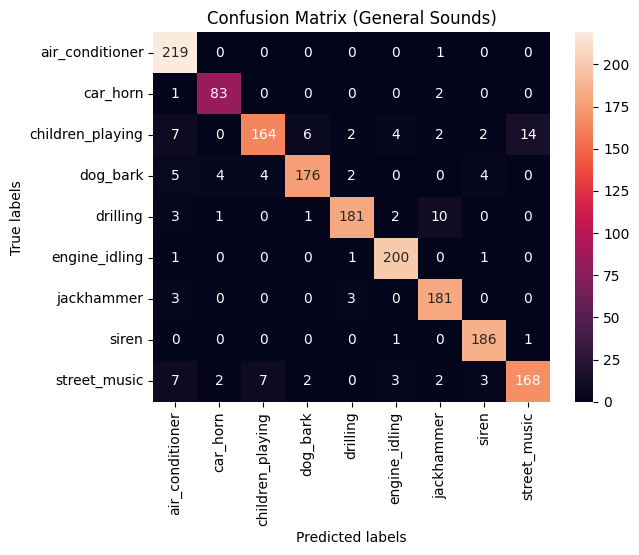

In [8]:
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (General Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()

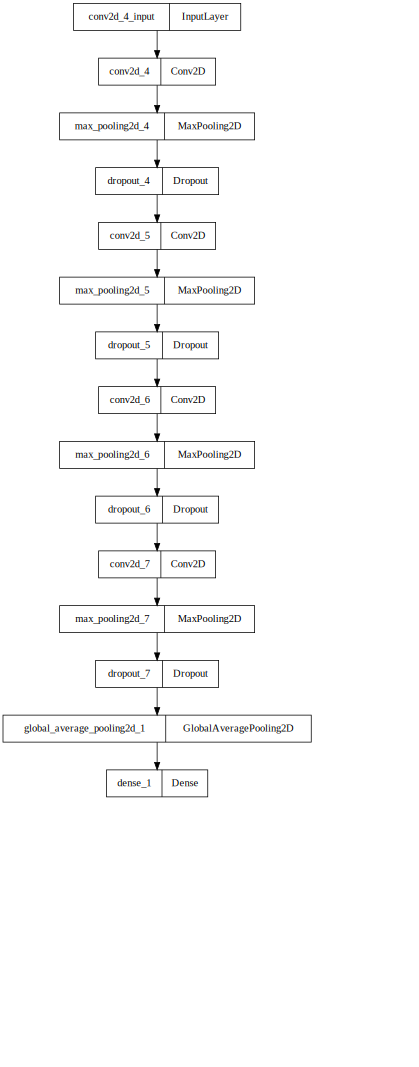

In [14]:
from IPython.display import SVG
from keras.utils import model_to_dot

# The output is a bit dodgy so you need to change the viewport value to
# width="550" height="1467" viewBox="0.00 0.00 550.00 1467.00"
with open("model_graph.svg", 'wb') as file:
    file.write(model_to_dot(model).create(prog='dot', format='svg'))
    
SVG("model_graph.svg")

### Test with sounds from odas

In [18]:
from os import listdir
from os.path import isfile, join

odas_clips = "../odassamples/" # <-- point the odas stuff to here or shove some samples in this folder

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f)) and f.endswith(".wav")]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))